In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path


In [45]:
ML_path = '/Users/nyki/Desktop/2025/Research Project/EarlySignalDetection'
shap_base = '/Users/nyki/Desktop/2025/Research Project/SHAP'

#### Data Loading & Preprocessing

In [3]:
DEMO_S = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/DEMO_S.parquet')
REAC_S = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/REAC_S.parquet')
DRUG_S = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/DRUG_S.parquet')
OUTC_S = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/OUTC_S.parquet')

In [4]:
un_set = set(DEMO_S.primaryid) & set(REAC_S.primaryid) & set(DRUG_S.primaryid)

In [5]:
DEMO = DEMO_S[DEMO_S.primaryid.isin(un_set)]
REAC = REAC_S[REAC_S.primaryid.isin(un_set)]
DRUG = DRUG_S[DRUG_S.primaryid.isin(un_set)]
OUTC = OUTC_S[OUTC_S.primaryid.isin(un_set)]

In [6]:

REAC.pt = REAC.pt.astype(str).str.upper()
DRUG.drugname = DRUG.drugname.astype(str).str.upper()

In [7]:

DEMO.to_parquet(f'{ML_path}/RAW_DATA.parquet/DEMO.parquet', index=False)
REAC.to_parquet(f'{ML_path}/RAW_DATA.parquet/REAC.parquet', index=False)
DRUG.to_parquet(f'{ML_path}/RAW_DATA.parquet/DRUG.parquet', index=False)
OUTC.to_parquet(f'{ML_path}/RAW_DATA.parquet/OUTC.parquet', index=False)

In [8]:
del DEMO,REAC,DRUG,OUTC,DEMO_S,REAC_S,DRUG_S,OUTC_S

In [10]:

DEMO_ = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/DEMO.parquet')
REAC_ = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/REAC.parquet')
DRUG_ = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/DRUG.parquet')
OUTC_ = pd.read_parquet(f'{ML_path}/RAW_DATA.parquet/OUTC.parquet')
# Date time format convert
DEMO_['fda_dt'] = pd.to_datetime(DEMO_['fda_dt'], format='%Y%m%d')

In [11]:
REAC = REAC_[REAC_.primaryid.isin(set(DEMO_.primaryid))]
DRUG = DRUG_[DRUG_.primaryid.isin(set(DEMO_.primaryid))]
OUTC = OUTC_[OUTC_.primaryid.isin(set(DEMO_.primaryid))]



In [12]:
DEMO =DEMO_.copy()
DEMO.shape[0]

22664957

###### used drug names: PROZAC+SARAFEM+PROZAC WEEKLY+FLUOXETINE HYDROCHLORIDE+FLUOXETINE

In [13]:
# Take target drugname as input
drugnames = input('Enter the drugname: ')

# Seperate multiply drugnames into list
drugname_list = drugnames.split('+')
print(f'Target drug: ', drugname_list)

Target drug:  ['PROZAC', 'SARAFEM', 'PROZAC WEEKLY', 'FLUOXETINE HYDROCHLORIDE', 'FLUOXETINE']


In [14]:
%%time
# To store unique report identifiers (primaryids) that are associated with the provided drug names
AER_ID = []

for drug in tqdm(drugname_list):
  # filter out rows from DRUG where drugname column is not empty and contais the uppercased target drug name
  # then extract the corresponding & unique report primaryid
    AER_ID_filtered = DRUG[DRUG['drugname'].notnull() & DRUG['drugname'].str.contains(str.upper(drug))].primaryid.unique()

  # cross-reference check with REAC:
  # filter out based on REAC to retain only reports (by primaryid) that appeared in filtered list
    AER_ID_filtered = REAC.loc[REAC['primaryid'].isin(AER_ID_filtered)].primaryid.unique()

  # Append filtered list to main list
    AER_ID.extend(AER_ID_filtered)

AED_ID = pd.Series(AER_ID)
AED_ID = AED_ID.unique().copy()
print('\n', f'Total number of recorded reports about target drug {drugname_list} is: ', len(AED_ID))


# To save computational time and be efficient
set_aedid = set(AED_ID)


100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


 Total number of recorded reports about target drug ['PROZAC', 'SARAFEM', 'PROZAC WEEKLY', 'FLUOXETINE HYDROCHLORIDE', 'FLUOXETINE'] is:  157041
CPU times: user 51.4 s, sys: 2.34 s, total: 53.8 s
Wall time: 54.5 s


In [18]:
# Extract data that only linked to target drug as our goal dataset
DRUG_GOAL = DRUG[DRUG['primaryid'].isin(set_aedid)]
REAC_GOAL = REAC[REAC['primaryid'].isin(set_aedid)]
DEMO_GOAL = DEMO[DEMO['primaryid'].isin(set_aedid)]
OUTC_GOAL = OUTC[OUTC['primaryid'].isin(set_aedid)]

print(REAC_GOAL.columns)
print(DEMO_GOAL.columns)
print(OUTC_GOAL.columns)
print(DRUG_GOAL.columns)

# Deuplicate
DEMO_GOAL = DEMO_GOAL.drop_duplicates(subset='primaryid', keep='first')
REAC_GOAL = REAC_GOAL.drop_duplicates(subset=['primaryid','pt'], keep='first')

print("\n", DEMO_GOAL.shape[0])
print(REAC_GOAL.shape[0])
print(DRUG_GOAL.shape[0])
print(OUTC_GOAL.shape[0])


Index(['primaryid', 'pt'], dtype='object')
Index(['primaryid', 'caseid', 'fda_dt', 'event_dt', 'sex', 'occp_cod',
       'reporter_country', 'age_group', 'age_years', 'weight_kg', 'wt_group'],
      dtype='object')
Index(['primaryid', 'outc_cod'], dtype='object')
Index(['primaryid', 'drug_seq', 'role_cod', 'drugname', 'route', 'dose_vbm',
       'dur_days', 'dur_group'],
      dtype='object')

 157041
868974
1759435
161435


In [ ]:
from importlib import reload
import LAB_ModelTrainer; reload(LAB_ModelTrainer)
import LAB_DataSplitter; reload(LAB_DataSplitter)
from LAB_ModelTrainer import split_data, train_model

X_train, X_test, y_train, y_test, feat = split_data(
    data_path=f"{shap_base}/ML_DATA_FEATURES.csv",
    target_col="Target",
    test_size=0.30,
    min_test_pos=1500,
    apply_smote=False,   # <- off here
    random_state=42,
)

model_path = train_model(
    X_train, y_train, X_test, y_test, feat,
    out_dir=f"{shap_base}/Model_Outputs",
    n_estimators=350, max_depth=6, learning_rate=0.05,
    subsample=0.7, colsample_bytree=0.7, early_stopping_rounds=75,
    tree_method="hist", random_state=42,
    gamma=0.40, min_child_weight=5.0, reg_alpha=0.50, reg_lambda=5.0,
    scale_pos_weight="auto",  # let it compute neg/pos from y_tr
    apply_smote=False
)



[CLEAN] Casting boolean columns to uint8: ['age_group_mode_0-2', 'age_group_mode_10-18', 'age_group_mode_18-30', 'age_group_mode_2-10', 'age_group_mode_30-45', 'age_group_mode_45-60', 'age_group_mode_60-80', 'age_group_mode_80+', 'age_group_mode_Unknown', 'drug_duration_mode_0-30 d', 'drug_duration_mode_121-150 d', 'drug_duration_mode_151-180 d', 'drug_duration_mode_181-360 d', 'drug_duration_mode_31-60 d', 'drug_duration_mode_360 d+', 'drug_duration_mode_61-90 d', 'drug_duration_mode_91-120 d', 'outc_cod_mode_CA', 'outc_cod_mode_DE', 'outc_cod_mode_DS', 'outc_cod_mode_HO', 'outc_cod_mode_LT', 'outc_cod_mode_OT', 'outc_cod_mode_RI', 'soc_n_Blood and lymphatic system disorders', 'soc_n_Cardiac disorders', 'soc_n_Congenital, familial and genetic disorders', 'soc_n_Ear and labyrinth disorders', 'soc_n_Endocrine disorders', 'soc_n_Eye disorders', 'soc_n_Gastrointestinal disorders', 'soc_n_General disorders and administration site conditions', 'soc_n_Hepatobiliary disorders', 'soc_n_Immune 

In [ ]:
from importlib import reload
import LAB_ModelTrainer; reload(LAB_ModelTrainer)
import LAB_DataSplitter; reload(LAB_DataSplitter)
from LAB_ModelTrainer import split_data, train_model

X_train, X_test, y_train, y_test, feat = split_data(
    data_path=f"{shap_base}/ML_DATA_FEATURES.csv",
    target_col="Target",
    test_size=0.30,
    min_test_pos=1500,
    apply_smote=False,   # <- off here
    random_state=42,
)

model_path = train_model(
    X_train, y_train, X_test, y_test, feat,
    out_dir=f"{shap_base}/Model_Outputs",
    n_estimators=350, max_depth=6, learning_rate=0.05,
    subsample=0.7, colsample_bytree=0.7, early_stopping_rounds=75,
    tree_method="hist", random_state=42,
    gamma=0.40, min_child_weight=5.0, reg_alpha=0.50, reg_lambda=5.0,
    scale_pos_weight="auto",  # let it compute neg/pos from y_tr
    apply_smote=False
)



[CLEAN] Casting boolean columns to uint8: ['age_group_mode_0-2', 'age_group_mode_10-18', 'age_group_mode_18-30', 'age_group_mode_2-10', 'age_group_mode_30-45', 'age_group_mode_45-60', 'age_group_mode_60-80', 'age_group_mode_80+', 'age_group_mode_Unknown', 'drug_duration_mode_0-30 d', 'drug_duration_mode_121-150 d', 'drug_duration_mode_151-180 d', 'drug_duration_mode_181-360 d', 'drug_duration_mode_31-60 d', 'drug_duration_mode_360 d+', 'drug_duration_mode_61-90 d', 'drug_duration_mode_91-120 d', 'outc_cod_mode_CA', 'outc_cod_mode_DE', 'outc_cod_mode_DS', 'outc_cod_mode_HO', 'outc_cod_mode_LT', 'outc_cod_mode_OT', 'outc_cod_mode_RI', 'soc_n_Blood and lymphatic system disorders', 'soc_n_Cardiac disorders', 'soc_n_Congenital, familial and genetic disorders', 'soc_n_Ear and labyrinth disorders', 'soc_n_Endocrine disorders', 'soc_n_Eye disorders', 'soc_n_Gastrointestinal disorders', 'soc_n_General disorders and administration site conditions', 'soc_n_Hepatobiliary disorders', 'soc_n_Immune 

In [20]:
print(DRUG_GOAL['dur_days'].isna().sum())

1583988


In [22]:
def safe_mode(series):
    s = series.dropna()
    if s.empty: 
        return np.nan
    # Most frequent; ties -> first by value_counts order
    return s.value_counts().idxmax()

def ratio_m_over_f(df, sex_col='sex'):
    if df.empty: 
        return np.nan
    m = (df[sex_col] == 'M').sum()
    f = (df[sex_col] == 'F').sum()
    return (m / f) if f else np.nan

def ensure_upper(df, col):
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
    return df

In [23]:
REAC_GOAL = ensure_upper(REAC_GOAL.copy(), 'pt')
DRUG_GOAL = ensure_upper(DRUG_GOAL.copy(), 'drugname')

In [24]:
print(REAC_GOAL.shape[0])
print(DRUG_GOAL.shape[0])

868974
1759435


In [25]:

# ------------------------------
# PT -> SOC mapping (soc_n)
# ------------------------------
soc_map = None
map_path = Path(f"{ML_path}/llt_to_soc.csv")
if map_path.exists():
    m = pd.read_csv(map_path)
    # allow a few common column name variants
    cand_pt = [c for c in m.columns if c.lower() in {'llt_n','pt','llt','preferred_term','pt_name'}]
    cand_soc = [c for c in m.columns if c.lower() in {'soc_n','soc','system_organ_class'}]
    if cand_pt and cand_soc:
        m = m[[cand_pt[0], cand_soc[0]]].copy()
        m.columns = ['PT','soc_n']
        m['PT'] = m['PT'].astype(str).str.strip().str.upper()
        soc_map = m.drop_duplicates()
else:
    print("Note: PT-SOC mapping not found; soc_n and soc_match will be NaN/0.")


In [26]:
soc_map

,PT,soc_n
0,VENTILATION PNEUMONITIS,"Respiratory, thoracic and mediastinal disorders"
1,11-BETA-HYDROXYLASE DEFICIENCY,"Congenital, familial and genetic disorders"
2,11-OXYSTEROID ACTIVITY INCR,Investigations
3,11-OXYSTEROID ACTIVITY INCREASED,Investigations
4,17 KETOSTEROIDS URINE,Investigations
...,...,...
89769,OUT OF SPECIFICATION RESULT NOT INVESTIGATED,Product issues
89770,MISSING BATCH PRODUCTION RECORD,Product issues
89771,OUT OF SPECIFICATION RESULT INVALIDATED WITHOU...,Product issues
89772,OUT OF SPECIFICATION RESULT INVALIDATED WITHOU...,Product issues


In [31]:
# ------------------------------
# Build all (drug, AE) pairs observed in the data
# ------------------------------
# Pair any report that contains a drug and the AE of that report
pairs = (REAC_GOAL[['primaryid','pt']]
         .merge(DRUG_GOAL[['primaryid','drugname']], on='primaryid', how='inner')
         .dropna(subset=['pt','drugname']))

pairs['pt'] = pairs['pt'].astype(str).str.strip().str.upper()
pairs['drugname'] = pairs['drugname'].astype(str).str.strip().str.upper()

# case reports (count of unique reports for (drug, AE))
case_reports = (pairs.groupby(['drugname','pt'])['primaryid']
                     .nunique().rename('case_reports').reset_index())
case_reports


,drugname,pt,case_reports
0,(-)-ECGONINE METHYL ESTER,DRUG INTERACTION,1
1,(-)-ECGONINE METHYL ESTER,HAEMORRHAGE,1
2,(-)-ECGONINE METHYL ESTER,INTENTIONAL PRODUCT MISUSE,1
3,(-)-ECGONINE METHYL ESTER,SUICIDAL IDEATION,1
4,(-)-ECGONINE METHYL ESTER,TOXICITY TO VARIOUS AGENTS,1
...,...,...,...
2278859,``MIDODRINE,MUSCLE INJURY,1
2278860,``MIDODRINE,MYOPATHY,1
2278861,``MIDODRINE,RENAL FAILURE,1
2278862,``MIDODRINE,RHABDOMYOLYSIS,1


In [33]:
def drop_invalid_text_rows(df, col="drugname"):
    placeholders = {"", "nan", "none", "null", "n/a", "na", "not available"}
    s = df[col].astype(str).str.strip()
    valid = (
        ~s.str.lower().isin(placeholders) &
        s.str.contains(r"[A-Za-z]", na=False) &
        ~s.str.match(r"^[^A-Za-z0-9]+$", na=False)
    )
    removed = len(df) - valid.sum()
    print(f"Removed {removed} rows with invalid {col}.")
    return df[valid].copy()

case_reports = drop_invalid_text_rows(case_reports, col="drugname")



Removed 814 rows with invalid drugname.


In [ ]:
# ------------------------------
# sex_ratio, age_group_mode, weight_group_mode, outc_cod_mode
# computed on the subset of reports where (drug, AE) co-occur
# -------------------------------------
# FAST merge-based pair feature builder

# 0) Keep unique (drugname, pt, primaryid) to avoid row explosion
pairs_unique = pairs[['drugname','pt','primaryid']].drop_duplicates()

# 1) Pre-prepare smaller DEMO/OUTC tables
DEMO_small = DEMO_GOAL[['primaryid','sex','age_group','wt_group']].copy()
OUTC_small = OUTC_GOAL[['primaryid','outc_cod']].copy()

# 2) Merge once (vectorized) instead of per-group isin scans
demo_merged = pairs_unique.merge(DEMO_small, on='primaryid', how='left')
outc_merged = pairs_unique.merge(OUTC_small, on='primaryid', how='left')

# 3) Helpers (fast + safe)
def _norm_sex_series(s: pd.Series) -> pd.Series:
    """Normalize sex codes to {'M','F'} when possible; keep others as-is/NaN."""
    x = s.astype(str).str.upper().str.strip()
    x = x.replace({'MALE': 'M', 'FEMALE': 'F'})
    # Treat invalid placeholders as NaN
    x = x.replace({'', 'NAN', 'NONE', 'UNKNOWN', 'UNK'}, np.nan)
    return x

def sex_ratio_m_over_f(s: pd.Series) -> float:
    """Compute M/F ratio; return np.nan if both are 0, np.inf if F==0<M."""
    x = _norm_sex_series(s)
    vc = x.value_counts(dropna=True)
    m = float(vc.get('M', 0.0))
    f = float(vc.get('F', 0.0))
    if m == 0 and f == 0:
        return np.nan
    if f == 0:
        return np.inf
    return m / f

def fast_mode(s: pd.Series):
    """Stable mode: return first of modes if tie; NaN if empty."""
    m = s.mode(dropna=True)
    return m.iat[0] if not m.empty else np.nan

# 4) Groupby aggregations (pure vectorized)
demo_agg = demo_merged.groupby(['drugname','pt']).agg(
    sex_ratio=('sex', sex_ratio_m_over_f),
    age_group_mode=('age_group', fast_mode),
    weight_group_mode=('wt_group', fast_mode),
)

outc_agg = outc_merged.groupby(['drugname','pt']).agg(
    outc_cod_mode=('outc_cod', fast_mode)
)

# 5) Combine
pair_feats = demo_agg.join(outc_agg, how='outer').reset_index()


In [ ]:
pair_feats.to_csv(f'{shap_base}/pair_feats.csv', index=False)

In [46]:
pair_feats = pd.read_csv(f'{shap_base}/pair_feats.csv')

In [47]:
# ------------------------------
# soc_n (PT SOC) and soc_match (AE SOC among top 5 SOCs for drug historically)
# ------------------------------
if soc_map is not None:
    # attach soc to each pair by PT
    soc_for_pair = pair_feats.merge(soc_map.rename(columns={'PT':'pt'}), on='pt', how='left')
else:
    soc_for_pair = pair_feats.copy()
    soc_for_pair['soc_n'] = np.nan

# Top 5 SOCs historically for each drug (using all their PTs from pairs)
if soc_map is not None:
    drug_soc_counts = (pairs[['drugname','pt']]
                       .drop_duplicates()
                       .merge(soc_map.rename(columns={'PT':'pt'}), on='pt', how='left')
                       .dropna(subset=['soc_n'])
                       .groupby(['drugname','soc_n'])
                       .size().rename('cnt').reset_index())
    top_soc = (drug_soc_counts.sort_values(['drugname','cnt'], ascending=[True, False])
               .groupby('drugname')
               .head(5))
    # mark soc_match
    soc_for_pair = soc_for_pair.merge(
        top_soc[['drugname','soc_n']].assign(soc_match=1),
        on=['drugname','soc_n'],
        how='left'
    )
    soc_for_pair['soc_match'] = soc_for_pair['soc_match'].fillna(0).astype(int)
else:
    soc_for_pair['soc_match'] = 0

In [48]:
# ------------------------------
# drug_duration_mode, drug_concomitant_avg (per drug overall, not conditioned on AE)
# ------------------------------
# duration mode per drug
dur_mode = (DRUG_GOAL.groupby('drugname')['dur_group']
                .apply(safe_mode)
                .rename('drug_duration_mode')
                .reset_index())

# concomitant avg per drug:
# For each report (primaryid), number of drugs reported -> for each drug in that report,
# concomitant = count_drugs_in_report - 1 ; average over all the drug's reports.
drug_counts_per_report = DRUG_GOAL.groupby('primaryid')['drugname'].nunique().rename('n_drugs')
drug_report = DRUG_GOAL[['primaryid','drugname']].drop_duplicates().merge(
    drug_counts_per_report, on='primaryid', how='left'
)
drug_report['concomitant'] = (drug_report['n_drugs'] - 1).clip(lower=0)
concomitant_avg = (drug_report.groupby('drugname')['concomitant']
                   .mean().rename('drug_concomitant_avg').reset_index())

In [ ]:
# ------------------------------
# Assemble ML dataset with selected features
# ------------------------------
ML = (case_reports
      .merge(soc_for_pair, on=['drugname','pt'], how='left')
      .merge(dur_mode, on='drugname', how='left')
      .merge(concomitant_avg, on='drugname', how='left'))

# Rename to match labels 
ML = ML.rename(columns={
    'drugname': 'DRUG',
    'pt': 'PT',
    'case_reports': 'CASE Reports',
    'sex_ratio': 'sex_ratio',
    'age_group_mode': 'age_group_mode',
    'weight_group_mode': 'weight_group_mode',
    'outc_cod_mode': 'outc_cod_mode',
    'soc_n': 'soc_n',
    'drug_duration_mode': 'drug_duration_mode',
    'drug_concomitant_avg': 'drug_concomitant_avg',
    'soc_match': 'soc_match'
})



In [239]:
ML

,DRUG,PT,CASE Reports,sex_ratio,age_group_mode,weight_group_mode,outc_cod_mode,soc_n,soc_match,drug_duration_mode,drug_concomitant_avg
0,(-)-ECGONINE METHYL ESTER,DRUG INTERACTION,1,NaN,NaN,NaN,DE,General disorders and administration site cond...,1,NaN,6.0
1,(-)-ECGONINE METHYL ESTER,HAEMORRHAGE,1,NaN,NaN,NaN,DE,Vascular disorders,1,NaN,6.0
2,(-)-ECGONINE METHYL ESTER,INTENTIONAL PRODUCT MISUSE,1,NaN,NaN,NaN,DE,"Injury, poisoning and procedural complications",1,NaN,6.0
3,(-)-ECGONINE METHYL ESTER,SUICIDAL IDEATION,1,NaN,NaN,NaN,DE,Psychiatric disorders,1,NaN,6.0
4,(-)-ECGONINE METHYL ESTER,TOXICITY TO VARIOUS AGENTS,1,NaN,NaN,NaN,DE,"Injury, poisoning and procedural complications",1,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...
2278045,``MIDODRINE,MUSCLE INJURY,1,inf,NaN,NaN,DE,"Injury, poisoning and procedural complications",1,NaN,16.0
2278046,``MIDODRINE,MYOPATHY,1,inf,NaN,NaN,DE,Musculoskeletal and connective tissue disorders,1,NaN,16.0
2278047,``MIDODRINE,RENAL FAILURE,1,inf,NaN,NaN,DE,Renal and urinary disorders,0,NaN,16.0
2278048,``MIDODRINE,RHABDOMYOLYSIS,1,inf,NaN,NaN,DE,Musculoskeletal and connective tissue disorders,1,NaN,16.0


In [337]:
ML.sample(n=10, random_state=42).to_excel(f'{shap_base}/ML_sample.xlsx', index=False)

In [240]:
# ------------------------------
# Data quality report (before imputation)
# ------------------------------
qc_before = ML.isna().sum().to_frame('missing_count')
qc_before['missing_pct'] = (qc_before['missing_count'] / len(ML)).round(4)

# ------------------------------
# Imputation strategy
#   - Numeric: median
#   - Categorical: mode
#   - Keep *_missing flags
# ------------------------------
numeric_cols = ['CASE Reports', 'sex_ratio', 'drug_concomitant_avg', 'soc_match']
cat_cols = ['age_group_mode', 'weight_group_mode', 'soc_n', 'outc_cod_mode', 'drug_duration_mode', 'DRUG', 'PT']

# flags
for col in numeric_cols + cat_cols:
    ML[f'{col}__missing'] = ML[col].isna().astype(int)

# numeric impute
for col in numeric_cols:
    if col in ML.columns:
        median_val = ML[col].median(skipna=True)
        ML[col] = ML[col].fillna(median_val)

# categorical impute
def mode_or_unknown(s):
    m = safe_mode(s)
    return 'UNKNOWN' if (pd.isna(m) or m == '' or m is None) else m

for col in cat_cols:
    if col in ML.columns:
        fill_val = mode_or_unknown(ML[col])
        ML[col] = ML[col].fillna(fill_val)



In [241]:
# ------------------------------
# Data quality report (after imputation)
# ------------------------------
qc_after = ML.isna().sum().to_frame('missing_count')
qc_after['missing_pct'] = (qc_after['missing_count'] / len(ML)).round(4)



In [242]:
qc_before

,missing_count,missing_pct
DRUG,0,0.0000
PT,0,0.0000
CASE Reports,0,0.0000
sex_ratio,66947,0.0294
age_group_mode,395470,0.1736
weight_group_mode,807447,0.3544
outc_cod_mode,343291,0.1507
soc_n,150,0.0001
soc_match,0,0.0000
drug_duration_mode,507813,0.2229


In [243]:
qc_after

,missing_count,missing_pct
DRUG,0,0.0
PT,0,0.0
CASE Reports,0,0.0
sex_ratio,0,0.0
age_group_mode,0,0.0
weight_group_mode,0,0.0
outc_cod_mode,0,0.0
soc_n,0,0.0
soc_match,0,0.0
drug_duration_mode,0,0.0


In [265]:
ML.drop(columns=['CASE Reports__missing', 'DRUG__missing', 'drug_concomitant_avg__missing','soc_match__missing', 'PT__missing'], inplace=True)

In [269]:
# ------------------------------
# Save outputs
# ------------------------------
ML.to_csv(f'{shap_base}/ML_DATA.csv')
qc_after.to_excel(f'{shap_base}/ML_DATA_QC.xlsx', index=False)

In [48]:
with pd.ExcelWriter(qc_after, engine='xlsxwriter') as writer:
    qc_before.to_excel(writer, sheet_name='missing_before')
    qc_after.to_excel(writer, sheet_name='missing_after')
    # include small samples for sanity check
    ML.head(50).to_excel(writer, sheet_name='sample_rows', index=False)

print(f"Saved ML dataset -> {ML.resolve()}")
print(f"Saved QC report  -> {qc_after.resolve()}")

ModuleNotFoundError: No module named 'xlsxwriter'

In [ ]:
ML_TEST = ML.copy()
# DROP COLUMNS ENDS WITH _missing
ML_TEST = ML_TEST.drop(
    columns=[col for col in ML_TEST.columns if col.endswith('_missing')])
# Save test dataset
ML_TEST.to_csv(f'{shap_base}/ML_DATA_TEST.csv', index=False)

In [317]:
ML_TEST

,DRUG,PT,CASE Reports,sex_ratio,age_group_mode,weight_group_mode,outc_cod_mode,soc_n,soc_match,drug_duration_mode,drug_concomitant_avg
0,(-)-ECGONINE METHYL ESTER,DRUG INTERACTION,1,0.0,45-60,60-75,DE,General disorders and administration site cond...,1,360 d+,6.0
1,(-)-ECGONINE METHYL ESTER,HAEMORRHAGE,1,0.0,45-60,60-75,DE,Vascular disorders,1,360 d+,6.0
2,(-)-ECGONINE METHYL ESTER,INTENTIONAL PRODUCT MISUSE,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0
3,(-)-ECGONINE METHYL ESTER,SUICIDAL IDEATION,1,0.0,45-60,60-75,DE,Psychiatric disorders,1,360 d+,6.0
4,(-)-ECGONINE METHYL ESTER,TOXICITY TO VARIOUS AGENTS,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0
...,...,...,...,...,...,...,...,...,...,...,...
2278045,``MIDODRINE,MUSCLE INJURY,1,inf,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,16.0
2278046,``MIDODRINE,MYOPATHY,1,inf,45-60,60-75,DE,Musculoskeletal and connective tissue disorders,1,360 d+,16.0
2278047,``MIDODRINE,RENAL FAILURE,1,inf,45-60,60-75,DE,Renal and urinary disorders,0,360 d+,16.0
2278048,``MIDODRINE,RHABDOMYOLYSIS,1,inf,45-60,60-75,DE,Musculoskeletal and connective tissue disorders,1,360 d+,16.0


In [312]:
ML

,DRUG,PT,CASE Reports,sex_ratio,age_group_mode,weight_group_mode,outc_cod_mode,soc_n,soc_match,drug_duration_mode,drug_concomitant_avg,sex_ratio__missing,age_group_mode__missing,weight_group_mode__missing,soc_n__missing,outc_cod_mode__missing,drug_duration_mode__missing
0,(-)-ECGONINE METHYL ESTER,DRUG INTERACTION,1,0.0,45-60,60-75,DE,General disorders and administration site cond...,1,360 d+,6.0,1,1,1,0,0,1
1,(-)-ECGONINE METHYL ESTER,HAEMORRHAGE,1,0.0,45-60,60-75,DE,Vascular disorders,1,360 d+,6.0,1,1,1,0,0,1
2,(-)-ECGONINE METHYL ESTER,INTENTIONAL PRODUCT MISUSE,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0,1,1,1,0,0,1
3,(-)-ECGONINE METHYL ESTER,SUICIDAL IDEATION,1,0.0,45-60,60-75,DE,Psychiatric disorders,1,360 d+,6.0,1,1,1,0,0,1
4,(-)-ECGONINE METHYL ESTER,TOXICITY TO VARIOUS AGENTS,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278045,``MIDODRINE,MUSCLE INJURY,1,inf,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,16.0,0,1,1,0,0,1
2278046,``MIDODRINE,MYOPATHY,1,inf,45-60,60-75,DE,Musculoskeletal and connective tissue disorders,1,360 d+,16.0,0,1,1,0,0,1
2278047,``MIDODRINE,RENAL FAILURE,1,inf,45-60,60-75,DE,Renal and urinary disorders,0,360 d+,16.0,0,1,1,0,0,1
2278048,``MIDODRINE,RHABDOMYOLYSIS,1,inf,45-60,60-75,DE,Musculoskeletal and connective tissue disorders,1,360 d+,16.0,0,1,1,0,0,1


In [271]:
for col in ML.columns:
    print(f"{col}: {ML[col].dtype} ({ML[col].nunique()} unique values)")

DRUG: object (52489 unique values)
PT: object (10139 unique values)
CASE Reports: int64 (823 unique values)
sex_ratio: float64 (6459 unique values)
age_group_mode: object (9 unique values)
weight_group_mode: object (6 unique values)
outc_cod_mode: object (7 unique values)
soc_n: object (27 unique values)
soc_match: int64 (2 unique values)
drug_duration_mode: object (8 unique values)
drug_concomitant_avg: float64 (6075 unique values)
sex_ratio__missing: int64 (2 unique values)
age_group_mode__missing: int64 (2 unique values)
weight_group_mode__missing: int64 (2 unique values)
soc_n__missing: int64 (2 unique values)
outc_cod_mode__missing: int64 (2 unique values)
drug_duration_mode__missing: int64 (2 unique values)


In [320]:
for col in ML_TEST.columns: 
    print(f"{col}: {ML_TEST[col].dtype} ({ML_TEST[col].nunique()} unique values)")

DRUG: object (52489 unique values)
PT: object (10139 unique values)
CASE Reports: int64 (823 unique values)
sex_ratio: float64 (6459 unique values)
age_group_mode: object (9 unique values)
weight_group_mode: object (6 unique values)
outc_cod_mode: object (7 unique values)
soc_n: object (27 unique values)
soc_match: int64 (2 unique values)
drug_duration_mode: object (8 unique values)
drug_concomitant_avg: float64 (6075 unique values)


In [295]:
from importlib import reload
import LAB_DataLoader; reload(LAB_DataLoader)
from LAB_DataLoader import DataLoader

csv_path = f"{shap_base}/ML_DATA.csv" 
loader = DataLoader(csv_path=csv_path, chunk_size=50_000, index_col=0)
df = loader.load()
df.head()


----------------------------------------------------------------------
[1/1] Loading data...
----------------------------------------------------------------------
  - Verifying file exists...
  - File size: 287.61 MB
  - Reading a small sample to confirm structure...
  - Sample shape: (100, 18)
  - Sample columns: ['Unnamed: 0', 'DRUG', 'PT', 'CASE Reports', 'sex_ratio', 'age_group_mode', 'weight_group_mode', 'outc_cod_mode', 'soc_n', 'soc_match', 'drug_duration_mode', 'drug_concomitant_avg', 'sex_ratio__missing', 'age_group_mode__missing', 'weight_group_mode__missing', 'soc_n__missing', 'outc_cod_mode__missing', 'drug_duration_mode__missing']
  - Starting chunked loading of full data...
    • Read 10 chunk(s)...
    • Read 20 chunk(s)...
    • Read 30 chunk(s)...
    • Read 40 chunk(s)...
  - Concatenating 46 chunk(s)...
✓ Data loaded: 2,278,050 rows, 17 columns


,DRUG,PT,CASE Reports,sex_ratio,age_group_mode,weight_group_mode,outc_cod_mode,soc_n,soc_match,drug_duration_mode,drug_concomitant_avg,sex_ratio__missing,age_group_mode__missing,weight_group_mode__missing,soc_n__missing,outc_cod_mode__missing,drug_duration_mode__missing
0,(-)-ECGONINE METHYL ESTER,DRUG INTERACTION,1,0.0,45-60,60-75,DE,General disorders and administration site cond...,1,360 d+,6.0,1,1,1,0,0,1
1,(-)-ECGONINE METHYL ESTER,HAEMORRHAGE,1,0.0,45-60,60-75,DE,Vascular disorders,1,360 d+,6.0,1,1,1,0,0,1
2,(-)-ECGONINE METHYL ESTER,INTENTIONAL PRODUCT MISUSE,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0,1,1,1,0,0,1
3,(-)-ECGONINE METHYL ESTER,SUICIDAL IDEATION,1,0.0,45-60,60-75,DE,Psychiatric disorders,1,360 d+,6.0,1,1,1,0,0,1
4,(-)-ECGONINE METHYL ESTER,TOXICITY TO VARIOUS AGENTS,1,0.0,45-60,60-75,DE,"Injury, poisoning and procedural complications",1,360 d+,6.0,1,1,1,0,0,1


In [304]:
from importlib import reload
import LAB_FeatureEngineering; reload(LAB_FeatureEngineering)
from LAB_FeatureEngineering import engineer_features

input_path = pd.read_csv(f"{shap_base}/ML_DATA.csv")
output_path = f"{shap_base}/ML_DATA_FEATURES.csv"
X_df, y = engineer_features(input_path, save_path=str(output_path))
print("Shapes:", X_df.shape, y.shape)
print("Target distribution:", y.value_counts().to_dict())
X_df.head()

----------------------------------------------------------------------
[2/8] Feature engineering...
----------------------------------------------------------------------
  - Checking columns...
  - Columns present: ['Unnamed: 0', 'DRUG', 'PT', 'CASE Reports', 'sex_ratio', 'age_group_mode', 'weight_group_mode', 'outc_cod_mode', 'soc_n', 'soc_match', 'drug_duration_mode', 'drug_concomitant_avg', 'sex_ratio__missing', 'age_group_mode__missing', 'weight_group_mode__missing', 'soc_n__missing', 'outc_cod_mode__missing', 'drug_duration_mode__missing']
[CLEAN] Dropping columns: ['Unnamed: 0']
  - Creating Target (from drug label ADRs)...
  - Target distribution: {0: 2047915, 1: 230135}
  - DRUG unique count: 52489
  - PT unique count:   10139
  - Dropped DRUG (high cardinality: 52489)
  - Dropped PT (high cardinality: 10139)
  - Dropped columns: ['Target', 'CASE Reports', 'soc_match', 'DRUG', 'PT']
  - Remaining feature count: 13
  - Numeric features: 8
  - Categorical features: 5
  - One-hot

,sex_ratio,drug_concomitant_avg,sex_ratio__missing,age_group_mode__missing,weight_group_mode__missing,soc_n__missing,outc_cod_mode__missing,drug_duration_mode__missing,age_group_mode_0-2,age_group_mode_10-18,...,soc_n_Surgical_and_medical_procedures,soc_n_Vascular_disorders,drug_duration_mode_0-30_d,drug_duration_mode_121-150_d,drug_duration_mode_151-180_d,drug_duration_mode_181-360_d,drug_duration_mode_31-60_d,drug_duration_mode_360_d+,drug_duration_mode_61-90_d,drug_duration_mode_91-120_d
0,0.0,6.0,1,1,1,0,0,1,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.0,6.0,1,1,1,0,0,1,False,False,...,False,True,False,False,False,False,False,True,False,False
2,0.0,6.0,1,1,1,0,0,1,False,False,...,False,False,False,False,False,False,False,True,False,False
3,0.0,6.0,1,1,1,0,0,1,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.0,6.0,1,1,1,0,0,1,False,False,...,False,False,False,False,False,False,False,True,False,False


In [308]:
from importlib import reload
import LAB_ModelTrainer; reload(LAB_ModelTrainer)
from LAB_ModelTrainer import split_and_balance, train_xgb, build_xgb_classifier


X_train_bal, X_test, y_train_bal, y_test = split_and_balance(
    X_df, y, test_size=0.30, random_state=42)

model = build_xgb_classifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=1.0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=1.0,  # keep 1.0 since we used SMOTE
)

model, train_time = train_xgb(X_train_bal, y_train_bal, model)

----------------------------------------------------------------------
[3/4] Splitting dataset...
----------------------------------------------------------------------
  - Train size: 1,594,635
  - Test size:  683,415
  - Train class balance (raw): {0: 1433540, 1: 161095}
  - Balancing training set with SMOTE...
  - Train size after SMOTE: 2,867,080
  - Train class balance (SMOTE): {0: 1433540, 1: 1433540}
✓ Split and balancing complete
----------------------------------------------------------------------
[4/4] Training XGBoost model...
----------------------------------------------------------------------
  - Model configured; starting fit...
✓ Model trained in 10.34s


In [309]:
from importlib import reload
import LAB_ModelEvaluater; reload(LAB_ModelEvaluater)
from LAB_ModelEvaluater import evaluate_model

metrics = evaluate_model(
    model_path=f"{shap_base}/Model_Outputs/XGB_MODEL.joblib",
    preds_path=f"{shap_base}/Model_Outputs/TEST_ARRAYS.npz",
    out_dir=f"{shap_base}/Model_Outputs/Evaluation")
metrics

[EVAL] AUROC: 0.9390 | AUPR: 0.0499
[EVAL] F1@0.5: 0.1132 | F1@bestF1(0.6035): 0.1197


{'auroc': 0.9389887750186326,
 'aupr': 0.049903942902933776,
 'threshold@0.5': 0.5,
 'accuracy@0.5': 0.9922593766299798,
 'precision@0.5': 0.07554760840411265,
 'recall@0.5': 0.22533333333333333,
 'f1@0.5': 0.11315701372614663,
 'best_threshold_f1': 0.6034923791885376,
 'accuracy@best_f1': 0.9934910386724348,
 'precision@best_f1': 0.08508845829823083,
 'recall@best_f1': 0.202,
 'f1@best_f1': 0.11973918197984589,
 'cm@0.5': [[678805, 4136], [1162, 338]],
 'cm@best_f1': [[679683, 3258], [1197, 303]],
 'report@best_f1': '              precision    recall  f1-score   support\n\n           0     0.9982    0.9952    0.9967    682941\n           1     0.0851    0.2020    0.1197      1500\n\n    accuracy                         0.9935    684441\n   macro avg     0.5417    0.5986    0.5582    684441\nweighted avg     0.9962    0.9935    0.9948    684441\n'}

In [ ]:
from importlib import reload
import LAB_Visualization; reload(LAB_Visualization)
from LAB_Visualization import render_dashboard, render_shap


#### Pre-SHAP

In [ ]:
# Label Target PTs 
import pandas as pd
import numpy as np
import re
import unicodedata

# --- PT set ---
true_signal_pts = { 
    'DEPRESSIVE SYMPTOM','DEPRESSED MOOD','ADJUSTMENT DISORDER WITH DEPRESSED MOOD',
    'OBSESSIVE-COMPULSIVE DISORDER','BULIMIA NERVOSA','PANIC DISORDER','ANOREXIA','ANXIETY',
    'ASTHENIA','DIARRHOEA','DIARRHOEA HAEMORRHAGIC','DRY MOUTH','DYSPEPSIA','INFLUENZA LIKE ILLNESS',
    'INFLUENZA','LIBIDO DECREASED','INSOMNIA','NAUSEA','NERVOUSNESS','NASOPHARYNGITIS','RASH',
    'SINUSITIS','SOMNOLENCE','NIGHT SWEATS','COLD SWEAT','TREMOR','VASODILATATION','YAWNING',
    'SUICIDAL IDEATION','BIPOLAR DISORDER','PARTIAL SEIZURES','DECREASED APPETITE','INCREASED APPETITE',
    'WEIGHT INCREASED','WEIGHT DECREASED','OVERWEIGHT','WEIGHT FLUCTUATION','HYPONATRAEMIA',
    'ANXIETY DISORDER','GENERALISED ANXIETY DISORDER','COGNITIVE DISORDER',
    'DRUG WITHDRAWAL SYNDROME','WITHDRAWAL SYNDROME','SEXUAL DYSFUNCTION',
    'ANGLE CLOSURE GLAUCOMA','ELECTROCARDIOGRAM QT PROLONGED','SEROTONIN SYNDROME'
}

# Fluent brand/synonym list (expandable)
fluoxetine_brands = {
    "PROZAC","SARAFEM","LOVAN","PROZAC WEEKLY","RAPIFLUX","SELFEMRA"
}
fluoxetine_generic = {"FLUOXETINE","FLUOXETINE HCL","FLUOXETINE HYDROCHLORIDE"}

# terms to strip from product strings
NOISE_TOKENS = {
    "HYDROCHLORIDE","HCL","TAB","TABS","TABLET","TABLETS","CAP","CAPS","CAPSULE","CAPSULES",
    "SOL","SOLUTION","SUSP","SUSPENSION","SYRUP","DR","ER","XR","CR","FILM","COATED","MG","ML","%","MCG",
    "TEVA","ACTAVIS","AUROBINDO","MYLAN","SANDOZ","HCL/","HYDROCHLORIDE/","HCL-","HYDROCHLORIDE-"
}

def normalize_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).map(lambda x: unicodedata.normalize("NFKC", x))
    s = s.str.upper().str.strip()
    # collapse whitespace and remove common punctuation
    s = s.str.replace(r"[^\w\s/()-]+", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True)
    return s

def strip_noise(drug_str: pd.Series) -> pd.Series:
    s = drug_str.copy()
    # remove strengths like "20MG", "5 MG/5 ML", etc.
    s = s.str.replace(r"\b\d+(\.\d+)?\s*(MG|MCG|G|ML|%)(/\s*\d+(\.\d+)?\s*(MG|MCG|ML))?\b", " ", regex=True)
    # remove parentheses content (often vendor/form)
    s = s.str.replace(r"\([^)]*\)", " ", regex=True)
    # remove known noise tokens
    pattern = r"\b(" + "|".join(map(re.escape, NOISE_TOKENS)) + r")\b"
    s = s.str.replace(pattern, " ", regex=True)
    # collapse spaces again
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s

def is_fluoxetine(drug_series: pd.Series) -> pd.Series:
    s = normalize_text(drug_series)
    s = strip_noise(s)
    # allow PLUS or slashes for combos
    s.str.contains(r"\bFLUOXETINE\b", regex=True) | s.str.contains(r"FLUOXETINE[+/]", regex=True)

    # quick contains for generic root
    contains_generic = s.str.contains(r"\bFLUOXETINE\b", regex=True)
    # brand contains
    brands_pat = r"\b(" + "|".join(map(re.escape, fluoxetine_brands)) + r")\b"
    contains_brand = s.str.contains(brands_pat, regex=True)
    # also handle common “generic + salt” forms (after noise strip many will already match generic)
    generic_pat = r"\b(" + "|".join(map(re.escape, fluoxetine_generic)) + r")\b"
    contains_generic_list = s.str.contains(generic_pat, regex=True)
    return contains_generic | contains_brand | contains_generic_list

def label_targets(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # sanity checks
    if not {"DRUG","PT"}.issubset(df.columns):
        raise ValueError("Input must contain DRUG and PT columns to label Target.")

    # normalize PT names
    pt_norm = normalize_text(df["PT"])

    drug_mask = is_fluoxetine(df["DRUG"])
    pt_mask   = pt_norm.isin({p.upper() for p in true_signal_pts})

    df["Target"] = (drug_mask & pt_mask).astype(int)

    # diagnostics
    print(f"Rows with DRUG recognized as fluoxetine: {int(drug_mask.sum())} / {len(df)}")
    print(f"Rows with PT in curated set: {int(pt_mask.sum())} / {len(df)}")
    print(f"Total positives (=both): {int(df['Target'].sum())}")

    # show samples to verify parsing
    print("\nSample recognized fluoxetine DRUG names:")
    print(df.loc[drug_mask, "DRUG"].dropna().astype(str).head(20).to_string(index=False))

    return df


df = pd.read_csv(f"{shap_base}/ML_DATA.csv")
df_labeled = label_targets(df)


Rows with DRUG recognized as fluoxetine: 38109 / 2278050
Rows with PT in curated set: 124839 / 2278050
Total positives (=both): 1581

Sample recognized fluoxetine DRUG names:
                            , FLUOXETINE
                            , FLUOXETINE
                            , FLUOXETINE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
12MG/50 MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZAPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZIPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZIPINE/FLUOXETINE CAPSULE
 12MG/50MG OLANZIPINE/FLUOXETINE CAPSULE


In [273]:
df_labeled['Target'].value_counts()

Target
0    2276469
1       1581
Name: count, dtype: int64

In [275]:

df_labeled = df_labeled.drop(columns=['Unnamed: 0'])
df_labeled.to_csv(f"{shap_base}/ML_DATA_LABELLED.csv", index=False)

In [276]:
print(df_labeled['Target'].dtypes)
df_labeled.shape

int64


(2278050, 18)

In [279]:
df_labeled.columns

Index(['DRUG', 'PT', 'CASE Reports', 'sex_ratio', 'age_group_mode',
       'weight_group_mode', 'outc_cod_mode', 'soc_n', 'soc_match',
       'drug_duration_mode', 'drug_concomitant_avg', 'sex_ratio__missing',
       'age_group_mode__missing', 'weight_group_mode__missing',
       'soc_n__missing', 'outc_cod_mode__missing',
       'drug_duration_mode__missing', 'Target'],
      dtype='object')

In [281]:
from importlib import reload
import LAB_DataLoader; reload(LAB_DataLoader)
from LAB_DataLoader import DataLoader

loader = DataLoader(
    data_path=f"{shap_base}/ML_DATA_LABELLED.csv",
    target_col="Target",
    drop_cols=["Unnamed: 0"],          # will be dropped if present
    include_identifiers_as_features=False,  # DRUG/PT excluded by default
    encode_categoricals=True,          # one-hot for: age_group_mode, weight_group_mode, outc_cod_mode, soc_n, drug_duration_mode
    keep_missing_indicators=True       # keep *_missing flags as features
)

X, y = loader.preprocess()
print(X.shape, type(y))
print("Columns sample:", list(X.columns)[:10])



[LOAD] Dataset shape: (2278050, 18). Columns: 18
[ENCODE] One-hot encoded categoricals: 5 → new width 67
[FEATURES] X shape: (2278050, 67). Numeric (base+flags) kept: 10, Categoricals encoded: 5, Identifiers used: 0
(2278050, 67) <class 'pandas.core.series.Series'>
Columns sample: ['CASE Reports', 'sex_ratio', 'soc_match', 'drug_concomitant_avg', 'sex_ratio__missing', 'age_group_mode__missing', 'weight_group_mode__missing', 'soc_n__missing', 'outc_cod_mode__missing', 'drug_duration_mode__missing']


In [282]:
from importlib import reload
import LAB_FeatureEngineering; reload(LAB_FeatureEngineering)
from LAB_FeatureEngineering import FeatureEngineer

fe = FeatureEngineer(
    target_col="Target",
    include_ids_as_features=False,
    winsorize_numeric=True,
    add_log1p_for=["CASE_Reports", "sex_ratio", "drug_concomitant_avg"],
    output_path=f"{shap_base}/ML_DATA_FEATURES.csv"
)

X_df, y, meta = fe.transform_path(f"{shap_base}/ML_DATA_LABELLED.csv", as_dataframe=True)
print(X_df.shape, y is not None)


[LOAD] Dataset shape: (2278050, 18). Columns: 18
[TARGET] Attached target 'Target'. Pos rate: 0.000694
[FEATURES] X shape: (2278050, 70). Missing flags kept: 6, Categoricals encoded: 5
[SAVE] Engineered features -> /Users/nyki/Desktop/2025/Research Project/SHAP/ML_DATA_FEATURES.csv
(2278050, 70) True


In [283]:
ML_FEATURES = X_df.copy()  
# ML_FEATURES.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
ML_FEATURES.columns

Index(['CASE_Reports', 'CASE_Reports_log1p', 'sex_ratio', 'sex_ratio_log1p',
       'drug_concomitant_avg', 'drug_concomitant_avg_log1p', 'soc_match',
       'age_group_mode__missing', 'drug_duration_mode__missing',
       'outc_cod_mode__missing', 'sex_ratio__missing', 'soc_n__missing',
       'weight_group_mode__missing', 'age_group_mode_0-2',
       'age_group_mode_10-18', 'age_group_mode_18-30', 'age_group_mode_2-10',
       'age_group_mode_30-45', 'age_group_mode_45-60', 'age_group_mode_60-80',
       'age_group_mode_80+', 'age_group_mode_Unknown',
       'drug_duration_mode_0-30 d', 'drug_duration_mode_121-150 d',
       'drug_duration_mode_151-180 d', 'drug_duration_mode_181-360 d',
       'drug_duration_mode_31-60 d', 'drug_duration_mode_360 d+',
       'drug_duration_mode_61-90 d', 'drug_duration_mode_91-120 d',
       'outc_cod_mode_CA', 'outc_cod_mode_DE', 'outc_cod_mode_DS',
       'outc_cod_mode_HO', 'outc_cod_mode_LT', 'outc_cod_mode_OT',
       'outc_cod_mode_RI', 'soc_n


=== CASE Reports ===
Count: 2278050
Mean: 5.583 | Median: 2.000
Min: 1.000 | Max: 4984.000
Skewness: 60.885 | Kurtosis: 7904.587


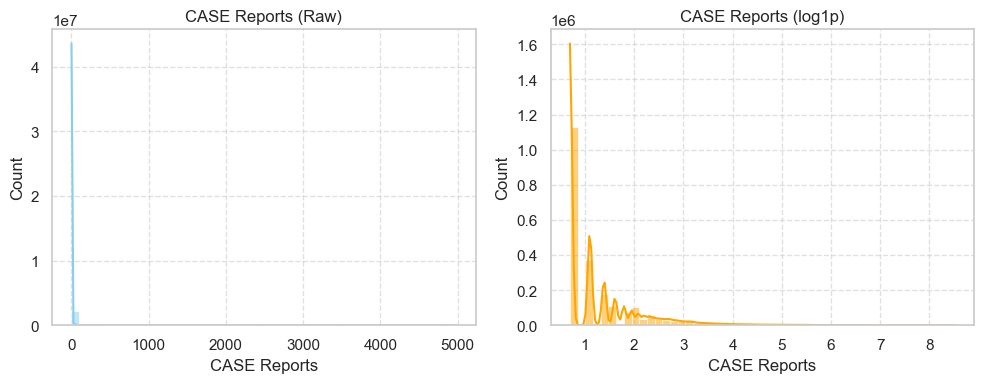


=== drug_concomitant_avg ===
Count: 2278050
Mean: 20.921 | Median: 18.804
Min: 0.000 | Max: 199.000
Skewness: 2.444 | Kurtosis: 11.273


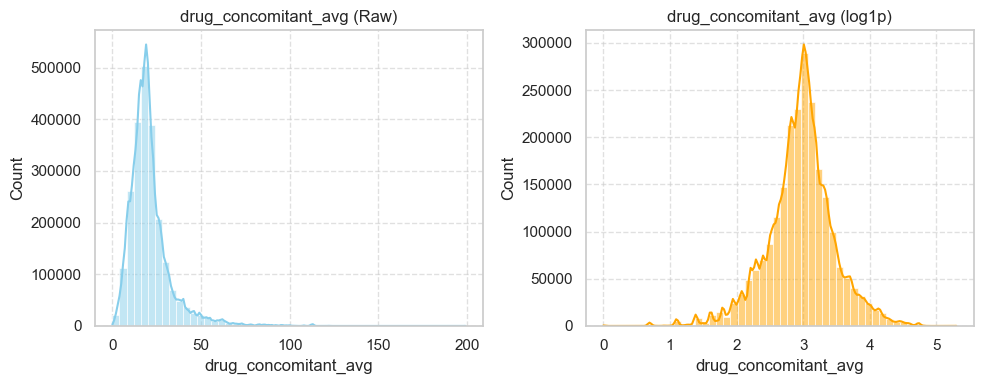


=== sex_ratio ===
Count: 2278050
Mean: inf | Median: 0.000
Min: 0.000 | Max: inf
Skewness: nan | Kurtosis: nan


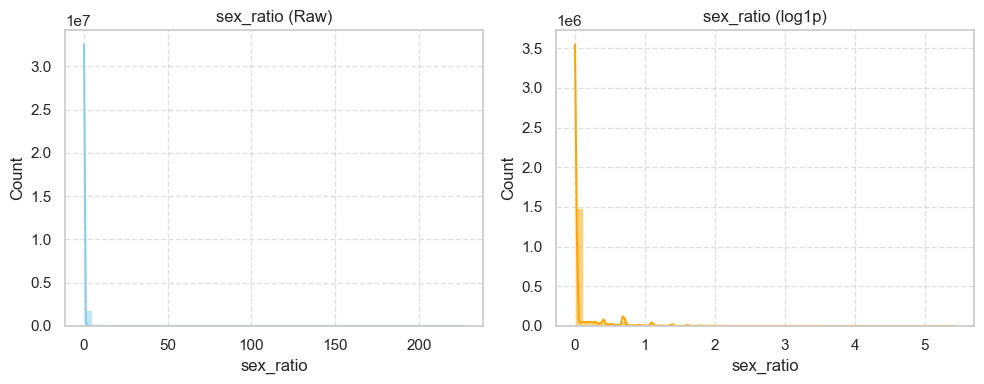

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
# Features to inspect
features_to_check = [
    'CASE Reports',
    'drug_concomitant_avg',
    'sex_ratio',
]

# Loop through features
for col in features_to_check:
    if col not in df_labeled.columns:
        print(f"[SKIP] {col} not found in dataset.")
        continue
    
    # Ensure numeric
    data = pd.to_numeric(df_labeled[col], errors="coerce").dropna()

    # Descriptive stats
    print(f"\n=== {col} ===")
    print(f"Count: {len(data)}")
    print(f"Mean: {data.mean():.3f} | Median: {data.median():.3f}")
    print(f"Min: {data.min():.3f} | Max: {data.max():.3f}")
    print(f"Skewness: {skew(data):.3f} | Kurtosis: {kurtosis(data):.3f}")
    
    # Plot distributions
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data, bins=50, ax=axes[0], kde=True, color="skyblue")
    axes[0].set_title(f"{col} (Raw)")
    
    log_data = np.log1p(data.clip(lower=0))
    sns.histplot(log_data, bins=50, ax=axes[1], kde=True, color="orange")
    axes[1].set_title(f"{col} (log1p)")
    
    for ax in axes:
        ax.set_xlabel(col)
        ax.grid(True, linestyle="--", alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [284]:
ML_DATA_FEATURES = pd.read_csv(f"{shap_base}/ML_DATA_FEATURES.csv")
ML_DATA_FEATURES.columns

Index(['Target', 'CASE_Reports', 'CASE_Reports_log1p', 'sex_ratio',
       'sex_ratio_log1p', 'drug_concomitant_avg', 'drug_concomitant_avg_log1p',
       'soc_match', 'age_group_mode__missing', 'drug_duration_mode__missing',
       'outc_cod_mode__missing', 'sex_ratio__missing', 'soc_n__missing',
       'weight_group_mode__missing', 'age_group_mode_0-2',
       'age_group_mode_10-18', 'age_group_mode_18-30', 'age_group_mode_2-10',
       'age_group_mode_30-45', 'age_group_mode_45-60', 'age_group_mode_60-80',
       'age_group_mode_80+', 'age_group_mode_Unknown',
       'drug_duration_mode_0-30 d', 'drug_duration_mode_121-150 d',
       'drug_duration_mode_151-180 d', 'drug_duration_mode_181-360 d',
       'drug_duration_mode_31-60 d', 'drug_duration_mode_360 d+',
       'drug_duration_mode_61-90 d', 'drug_duration_mode_91-120 d',
       'outc_cod_mode_CA', 'outc_cod_mode_DE', 'outc_cod_mode_DS',
       'outc_cod_mode_HO', 'outc_cod_mode_LT', 'outc_cod_mode_OT',
       'outc_cod_mode_R

In [287]:
from importlib import reload
import LAB_ModelTrainer; reload(LAB_ModelTrainer)
import LAB_DataSplitter; reload(LAB_DataSplitter)
from LAB_ModelTrainer import split_data, train_model

X_train, X_test, y_train, y_test, feat = split_data(
    data_path=f"{shap_base}/ML_DATA_FEATURES.csv",
    target_col="Target",
    test_size=0.30,
    min_test_pos=1500,
    apply_smote=False,   # <- off here
    random_state=42,
)

model_path = train_model(
    X_train, y_train, X_test, y_test, feat,
    out_dir=f"{shap_base}/Model_Outputs",
    n_estimators=350, max_depth=6, learning_rate=0.05,
    subsample=0.7, colsample_bytree=0.7, early_stopping_rounds=75,
    tree_method="hist", random_state=42,
    gamma=0.40, min_child_weight=5.0, reg_alpha=0.50, reg_lambda=5.0,
    scale_pos_weight="auto",  # let it compute neg/pos from y_tr
    apply_smote=False
)



[CLEAN] Casting boolean columns to uint8: ['age_group_mode_0-2', 'age_group_mode_10-18', 'age_group_mode_18-30', 'age_group_mode_2-10', 'age_group_mode_30-45', 'age_group_mode_45-60', 'age_group_mode_60-80', 'age_group_mode_80+', 'age_group_mode_Unknown', 'drug_duration_mode_0-30 d', 'drug_duration_mode_121-150 d', 'drug_duration_mode_151-180 d', 'drug_duration_mode_181-360 d', 'drug_duration_mode_31-60 d', 'drug_duration_mode_360 d+', 'drug_duration_mode_61-90 d', 'drug_duration_mode_91-120 d', 'outc_cod_mode_CA', 'outc_cod_mode_DE', 'outc_cod_mode_DS', 'outc_cod_mode_HO', 'outc_cod_mode_LT', 'outc_cod_mode_OT', 'outc_cod_mode_RI', 'soc_n_Blood and lymphatic system disorders', 'soc_n_Cardiac disorders', 'soc_n_Congenital, familial and genetic disorders', 'soc_n_Ear and labyrinth disorders', 'soc_n_Endocrine disorders', 'soc_n_Eye disorders', 'soc_n_Gastrointestinal disorders', 'soc_n_General disorders and administration site conditions', 'soc_n_Hepatobiliary disorders', 'soc_n_Immune 

In [ ]:
from importlib import reload
import LAB_ModelEvaluater; reload(LAB_ModelEvaluater)
from LAB_ModelEvaluater import evaluate_model

metrics = evaluate_model(
    model_path=f"{shap_base}/Model_Outputs/xgb_model.joblib",
    preds_path=f"{shap_base}/Model_Outputs/test_arrays.npz",
    out_dir=f"{shap_base}/Model_Outputs/Evaluation")

metrics


{'prevalence': 0.0021915694705606473,
 'auroc': 0.9389887750186326,
 'aupr': 0.049903942902933776,
 'brier': 0.006085438890584069,
 'ks': 0.7446907419528187,
 'accuracy@0.5': 0.9922593766299798,
 'precision@0.5': 0.07554760840411265,
 'recall@0.5': 0.22533333333333333,
 'f1@0.5': 0.11315701372614663,
 'cm@0.5': [[678805, 4136], [1162, 338]],
 'best_threshold_f1': 0.6034923791885376,
 'report@best_f1': '              precision    recall  f1-score   support\n\n           0     0.9982    0.9952    0.9967    682941\n           1     0.0851    0.2020    0.1197      1500\n\n    accuracy                         0.9935    684441\n   macro avg     0.5417    0.5986    0.5582    684441\nweighted avg     0.9962    0.9935    0.9948    684441\n',
 'cm@best_f1': [[679683, 3258], [1197, 303]],
 'thr@precision>=0.20': 0.993606686592102,
 'cm@p>=0.20': [[682911, 30], [1492, 8]],
 'thr@recall>=0.50': 0.08318845182657242,
 'cm@r>=0.50': [[665873, 17068], [750, 750]],
 'precision@top_0.01pct': 0.1323529411

In [294]:
metrics['report@best_f1']

'              precision    recall  f1-score   support\n\n           0     0.9982    0.9952    0.9967    682941\n           1     0.0851    0.2020    0.1197      1500\n\n    accuracy                         0.9935    684441\n   macro avg     0.5417    0.5986    0.5582    684441\nweighted avg     0.9962    0.9935    0.9948    684441\n'

{'beeswarm': '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Summary_Beeswarm.png',
 'bar': '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Feature_Importance.png',
 'interaction': '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Features_Interaction_Matrix.png',
 'waterfall': '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Waterfall.png',
 'force_html': '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Force_Plot.html',
 'dependence': ['/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Dependence_TOP1.png',
  '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Dependence_TOP2.png',
  '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Dependence_TOP3.png',
  '/Users/nyki/Desktop/2025/Research Project/SHAP/Model_Outputs/Evaluation/SHAP_Dependence_TOP4.png']}

<Figure size 800x600 with 0 Axes>

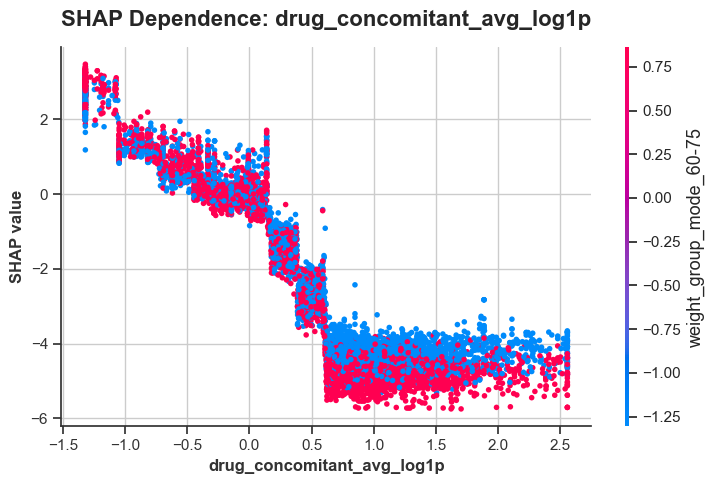

<Figure size 800x600 with 0 Axes>

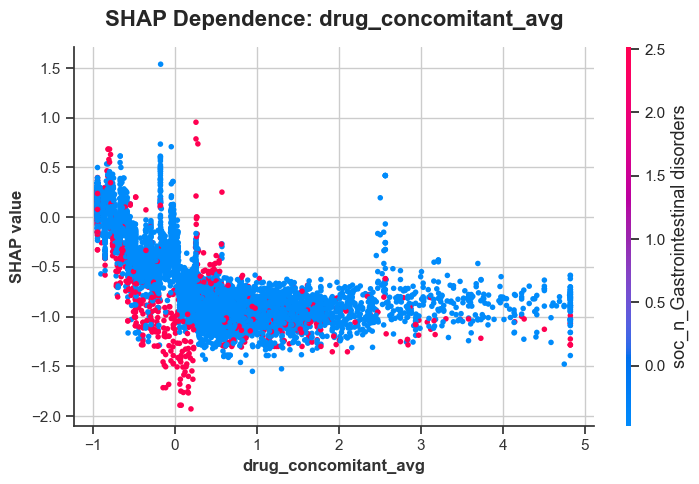

<Figure size 800x600 with 0 Axes>

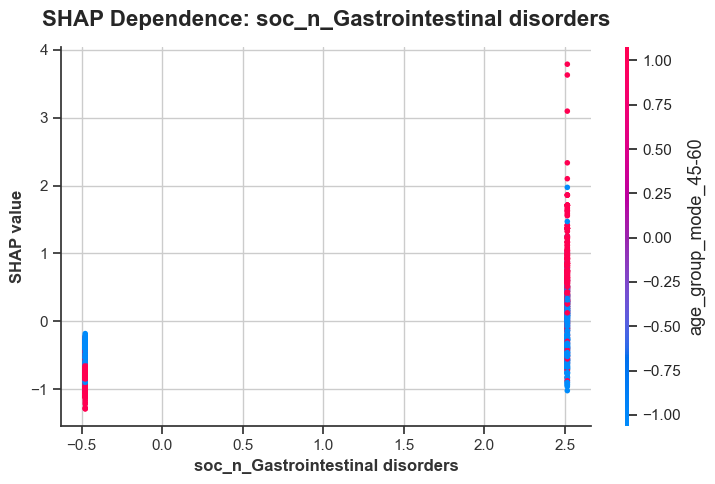

<Figure size 800x600 with 0 Axes>

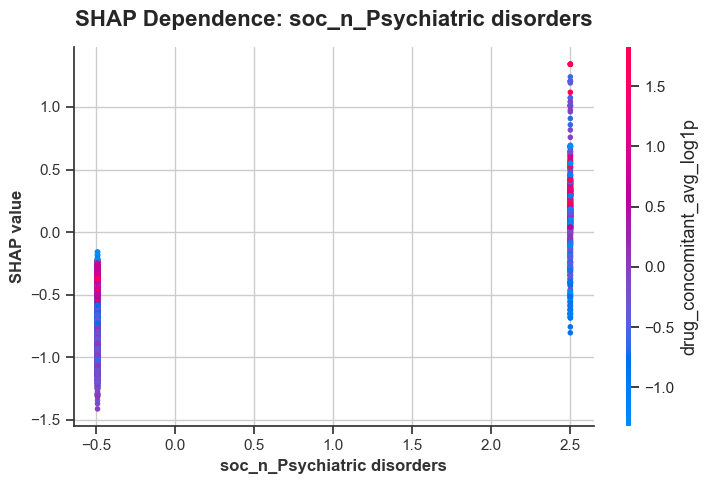

In [218]:
from importlib import reload
import LAB_Visualization; reload(LAB_Visualization)
from LAB_Visualization import render_dashboard, render_shap

# 1) Dashboard (confusion, metrics, ROC, PR, feature importance)
dash = render_dashboard(
    artifacts_dir=f"{shap_base}/Model_Outputs/Evaluation",
    model_path=f"{shap_base}/Model_Outputs/xgb_model.joblib",  # optional
    top_n_importance=15
)
dash

# 2) SHAP plots (model + X_test)
shap_out = render_shap(
    artifacts_dir=f"{shap_base}/Model_Outputs/Evaluation",
    model_path=f"{shap_base}/Model_Outputs/XGB_MODEL.joblib",
    test_arrays_path=f"{shap_base}/Model_Outputs/TEST_ARRAYS.npz",  # produced by trainer
    shap_sample=8000,      # reduce if it’s slow
    top_n_display=20,
    top_k_interact=8,
    top_k_dependence=4
)
shap_out


#### DEBUG

In [219]:
import os, json, joblib, numpy as np, pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix, classification_report
)

base = f"{shap_base}/Model_Outputs"  # <- change if different
model_path = os.path.join(base, "xgb_model.joblib")
test_npz    = os.path.join(base, "test_arrays.npz")
metrics_json= os.path.join(base, "evaluation", "metrics.json") if os.path.exists(os.path.join(base, "evaluation", "metrics.json")) else None

bundle = joblib.load(model_path)
model = bundle["model"]
feature_names = bundle["feature_names"]

arr = np.load(test_npz, allow_pickle=True)
X_test = arr["X_test"]; y_test = arr["y_test"]

y_proba = model.predict_proba(X_test)[:, 1]
y_pred05 = (y_proba >= 0.5).astype(int)

print("Shapes:", X_test.shape, y_test.shape)
print("Prevalence (test):", float((y_test==1).mean()))
print("AUROC:", roc_auc_score(y_test, y_proba), "AUPR:", average_precision_score(y_test, y_proba))
print("CM@0.5:\n", confusion_matrix(y_test, y_pred05))


Shapes: (684441, 63) (684441,)
Prevalence (test): 0.0021915694705606473
AUROC: 0.9328871513058961 AUPR: 0.04969032655710031
CM@0.5:
 [[681776   1165]
 [  1370    130]]


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2*prec*rec/(prec+rec+1e-12)

def pick_by(metric="f1", target=None):
    if metric=="f1":
        i = int(np.nanargmax(f1s))
    elif metric=="precision>=target":
        idx = np.where(prec >= target)[0]
        i = idx[0] if len(idx)>0 else np.argmax(prec)   # highest precision available
    elif metric=="recall>=target":
        idx = np.where(rec >= target)[0]
        i = idx[-1] if len(idx)>0 else np.argmax(rec)
    else:
        raise ValueError
    thr_star = thr[i-1] if i>0 and i-1 < len(thr) else 0.5
    y_pred = (y_proba >= thr_star).astype(int)
    return dict(
        i=i, threshold=float(thr_star),
        precision=float(precision_score(y_test, y_pred, zero_division=0)),
        recall=float(recall_score(y_test, y_pred, zero_division=0)),
        f1=float(f1_score(y_test, y_pred, zero_division=0)),
        support=int(y_pred.sum())
    )

best_f1     = pick_by("f1")
p_at_50     = pick_by("precision>=target", target=0.50)  
r_at_70     = pick_by("recall>=target",    target=0.70)

best_f1, p_at_50, r_at_70


({'i': 230436,
  'threshold': 0.2006448358297348,
  'precision': 0.08204419889502762,
  'recall': 0.198,
  'f1': 0.116015625,
  'support': 3620},
 {'i': 231485,
  'threshold': 0.985443115234375,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'support': 4},
 {'i': 214930,
  'threshold': 0.007399545516818762,
  'precision': 0.02883110464318076,
  'recall': 0.7,
  'f1': 0.05538120731031936,
  'support': 36419})

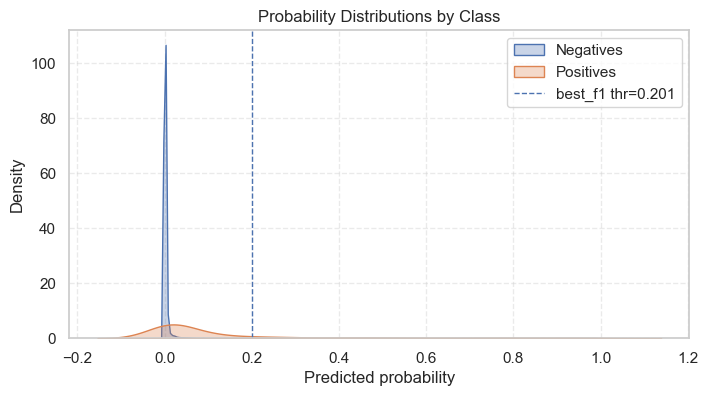

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.kdeplot(y_proba[y_test==0], label="Negatives", fill=True, alpha=.3)
sns.kdeplot(y_proba[y_test==1], label="Positives", fill=True, alpha=.3)
plt.axvline(best_f1['threshold'], ls="--", lw=1, label=f"best_f1 thr={best_f1['threshold']:.3f}")
plt.title("Probability Distributions by Class")
plt.xlabel("Predicted probability"); plt.legend(); plt.grid(True, ls='--', alpha=.4)
plt.show()


In [222]:
y_pred_star = (y_proba >= best_f1['threshold']).astype(int)

def cohort_idx(y_true, y_pred):
    TP = np.where((y_true==1)&(y_pred==1))[0]
    FP = np.where((y_true==0)&(y_pred==1))[0]
    FN = np.where((y_true==1)&(y_pred==0))[0]
    TN = np.where((y_true==0)&(y_pred==0))[0]
    return TP, FP, FN, TN

TP, FP, FN, TN = cohort_idx(y_test, y_pred_star)
len(TP), len(FP), len(FN), len(TN)


(297, 3323, 1203, 679618)

In [223]:
import shap
import numpy as np
import pandas as pd

# Create a compact frame for SHAP
Xdf = pd.DataFrame(X_test, columns=feature_names)

# Subsample for speed if huge:
N = min(8000, len(Xdf))
rng = np.random.RandomState(42)
rows = rng.choice(np.arange(len(Xdf)), size=N, replace=False)

explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(Xdf.iloc[rows])

# Map rows to FP/TP/FN/TN on the sampled subset
ys = y_test[rows]; ps = y_proba[rows]; preds = (ps >= best_f1['threshold']).astype(int)
TPs, FPs, FNs, TNs = cohort_idx(ys, preds)

def top_drivers(indices, k=15, title=""):
    if len(indices)==0:
        print(f"{title}: none"); return None
    sv = np.abs(shap_vals[indices])
    mean_abs = sv.mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:k]
    print(f"\nTop drivers for {title}:")
    for i in order:
        print(f"{feature_names[i]:40s}  {mean_abs[i]:.5f}")
    return order

top_drivers(FPs, k=20, title="FALSE POSITIVES")
top_drivers(FNs, k=20, title="FALSE NEGATIVES")



Top drivers for FALSE POSITIVES:
drug_concomitant_avg_log1p                2.48158
soc_n_Gastrointestinal disorders          0.73988
soc_n_Psychiatric disorders               0.36049
age_group_mode_45-60                      0.28892
drug_concomitant_avg                      0.24489
weight_group_mode_60-75                   0.22464
drug_duration_mode_360 d+                 0.22168
soc_n_Metabolism and nutrition disorders  0.21327
outc_cod_mode_HO                          0.19252
soc_n_Investigations                      0.18078
soc_match                                 0.17178
CASE Reports                              0.15406
drug_duration_mode_0-30 d                 0.14774
outc_cod_mode_OT                          0.12596
age_group_mode_60-80                      0.12257
age_group_mode_30-45                      0.11260
soc_n_General disorders and administration site conditions  0.09201
sex_ratio                                 0.09140
sex_ratio_log1p                           0.0870

array([ 3, 49, 36, 11, 59, 26,  5,  2,  8, 20, 15, 46,  4,  1, 37, 43, 10,
        0, 28, 12])

In [224]:
# Columns that start with "soc_n_"
soc_cols = [c for c in feature_names if c.startswith("soc_n_")]
fp_mean = Xdf.iloc[rows[FPs]][soc_cols].mean().sort_values(ascending=False).head(10)
tp_mean = Xdf.iloc[rows[TPs]][soc_cols].mean().sort_values(ascending=False).head(10)
pd.DataFrame({"FP_soc": fp_mean, "TP_soc": tp_mean}).fillna(0)


,FP_soc,TP_soc
"soc_n_Congenital, familial and genetic disorders",-0.056736,-0.056736
soc_n_Ear and labyrinth disorders,-0.058181,-0.058181
soc_n_Endocrine disorders,-0.051880,-0.051880
soc_n_Eye disorders,0.273726,0.000000
soc_n_Gastrointestinal disorders,0.060051,0.720203
soc_n_General disorders and administration site conditions,0.000000,0.447532
soc_n_Immune system disorders,0.000000,-0.064576
soc_n_Investigations,0.084123,0.000000
soc_n_Metabolism and nutrition disorders,0.234481,0.000000
soc_n_Nervous system disorders,0.000000,1.171378


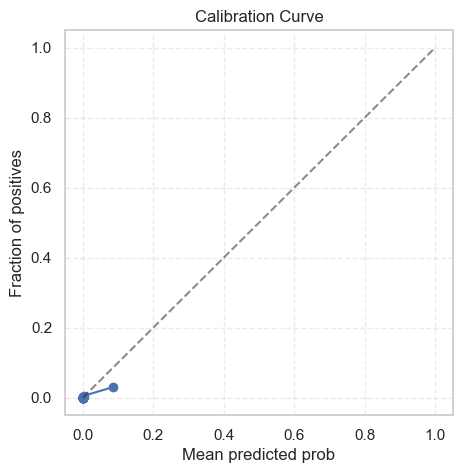

In [225]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=20, strategy='quantile')
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--', alpha=.5)
plt.title("Calibration Curve"); plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction of positives"); plt.grid(True, ls='--', alpha=.4)
plt.show()


In [226]:
def precision_at_k(y_true, y_score, k):
    idx = np.argsort(y_score)[::-1][:k]
    return float(y_true[idx].mean())

n = len(y_test)
for frac in [0.001, 0.005, 0.01, 0.02]:  # top 0.1%, 0.5%, 1%, 2%
    k = max(1, int(n*frac))
    print(f"precision@top-{frac*100:.1f}% (k={k}): {precision_at_k(y_test, y_proba, k):.4f}")


precision@top-0.1% (k=684): 0.1140
precision@top-0.5% (k=3422): 0.0821
precision@top-1.0% (k=6844): 0.0662
precision@top-2.0% (k=13688): 0.0516
